# Gate based workflow

This notebook shows an example of how a gate based computation (in this case using `qiskit`) could be integrated into `qse`.

In [1]:
import qse
import numpy as np
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import efficient_su2
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.circuit import QuantumCircuit

## Step 1: Create qbits object

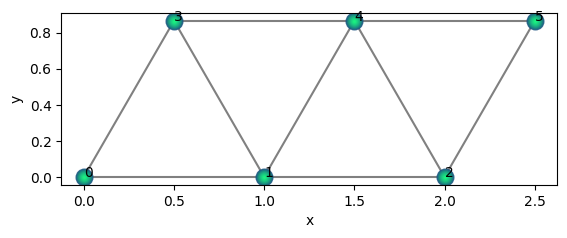

In [2]:
h = np.sqrt(1 - 0.5 * 0.5)

positions = np.array(
    [
        [0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0],
        [2.0, 0.0, 0.0],
        [0.5, h, 0.0],
        [1.5, h, 0.0],
        [2.5, h, 0.0],
    ]
)

qbits = qse.Qbits(positions=positions)
qbits.draw(show_labels=True, radius="nearest")

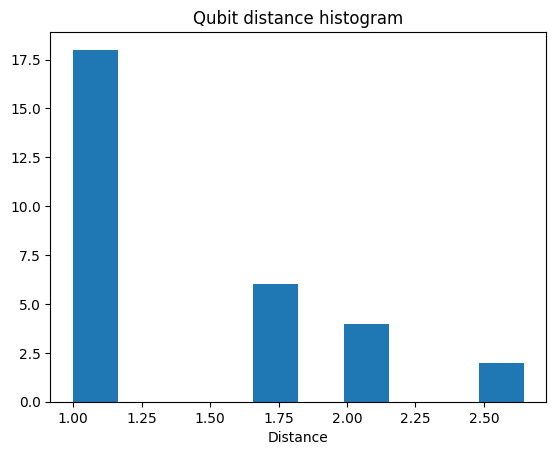

In [4]:
plt.hist([i for i in qbits.get_all_distances().flatten() if i > 0.01])
plt.title("Qubit distance histogram")
plt.xlabel("Distance")
plt.show()

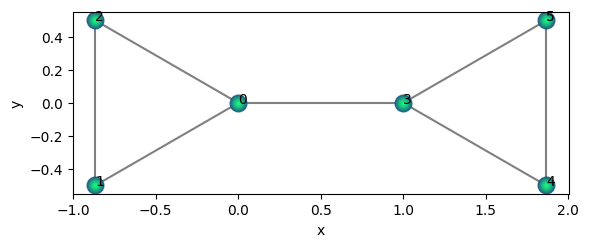

In [5]:
h = np.sqrt(1 - 0.5 * 0.5)

positions = np.array(
    [
        [0.0, 0.0, 0.0],
        [-h, -0.5, 0.0],
        [-h, 0.5, 0.0],
        [1.0, 0.0, 0.0],
        [1 + h, -0.5, 0.0],
        [1 + h, 0.5, 0.0],
    ]
)

qbits = qse.Qbits(positions=positions)
qbits.draw(show_labels=True, radius="nearest")

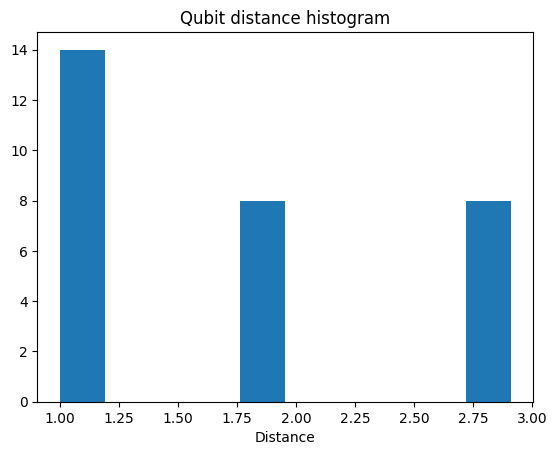

In [6]:
plt.hist([i for i in qbits.get_all_distances().flatten() if i > 0.01])
plt.title("Qubit distance histogram")
plt.xlabel("Distance")
plt.show()

# Step 2: Define a distance function to create an interaction Hamiltonian that's based on the geometry of the qubits.

In [7]:
def distance_func(distance, tolerance=0.01):
    """
    Simple distance function that only includes nearest neighbours.

    This function returns a coefficient of 1.0 if the input distance is approximately 1.0
    (within a specified tolerance), otherwise it returns 0.0.
    """
    if np.abs(distance - 1) < tolerance:
        return 1.0
    return 0.0

In [8]:
# simple ZZ coupling
coupling = qbits.compute_interaction_hamiltonian(distance_func, "Z")
coupling
# We can easily do something more complicated like a Heisenberg model:
# coupling =
# qbits.compute_interaction_hamiltonian(distance_func, "X") +
# qbits.compute_interaction_hamiltonian(distance_func, "Y") +
# qbits.compute_interaction_hamiltonian(distance_func, "Z")

[1.00 Z0 Z1,
 1.00 Z0 Z2,
 1.00 Z0 Z3,
 1.00 Z1 Z2,
 1.00 Z3 Z4,
 1.00 Z3 Z5,
 1.00 Z4 Z5]

In [9]:
ext_field = [qse.Operator("X", i, 1.0, qbits.nqbits) for i in range(qbits.nqbits)]
ext_field

[1.00 X0, 1.00 X1, 1.00 X2, 1.00 X3, 1.00 X4, 1.00 X5]

In [10]:
hamiltonian = coupling + ext_field
hamiltonian

[1.00 Z0 Z1,
 1.00 Z0 Z2,
 1.00 Z0 Z3,
 1.00 Z1 Z2,
 1.00 Z3 Z4,
 1.00 Z3 Z5,
 1.00 Z4 Z5,
 1.00 X0,
 1.00 X1,
 1.00 X2,
 1.00 X3,
 1.00 X4,
 1.00 X5]

## Step 3: Run in qiskit
Here we use a simple VQE workflow.

In [11]:
hamiltonian_qiskit = SparsePauliOp(
    [i.to_str() for i in hamiltonian], [i.coef for i in hamiltonian]
)
print(hamiltonian_qiskit)
ansatz = efficient_su2(qbits.nqbits, reps=1)

SparsePauliOp(['ZZIIII', 'ZIZIII', 'ZIIZII', 'IZZIII', 'IIIZZI', 'IIIZIZ', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [12]:
def compute_expectation(params):
    """Compute the expectation value of a quantum operator using a statevector simulator."""
    estimator = StatevectorEstimator()

    pub = (ansatz, hamiltonian_qiskit, params)
    job = estimator.run([pub])

    return job.result()[0].data.evs


def run_sampler(params, shots=1000):
    """Sample a circuit using a statevector simulator."""
    sampler = StatevectorSampler()

    circuit = QuantumCircuit(ansatz.num_qubits)
    circuit.append(ansatz, range(ansatz.num_qubits))
    circuit.measure_all()

    pub = (circuit, params)
    job = sampler.run([pub], shots=shots)

    return job.result()[0].data.meas.get_counts()

In [13]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

cost_hist = []
opt_result = minimize(
    compute_expectation,
    x0,
    method="BFGS",
    callback=lambda intermediate_result: cost_hist.append(intermediate_result.fun),
)
opt_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -6.839108621944124
        x: [ 6.608e+00  1.829e-01 ...  3.206e+00  2.269e+00]
      nit: 136
      jac: [ 7.749e-07 -4.172e-07 ...  5.364e-07 -5.960e-08]
 hess_inv: [[ 4.487e-01 -7.747e-02 ...  1.160e-02  1.365e-01]
            [-7.747e-02  4.820e-01 ... -8.475e-02 -4.285e-01]
            ...
            [ 1.160e-02 -8.475e-02 ...  1.789e+02  4.709e+02]
            [ 1.365e-01 -4.285e-01 ...  4.709e+02  1.455e+03]]
     nfev: 3800
     njev: 152

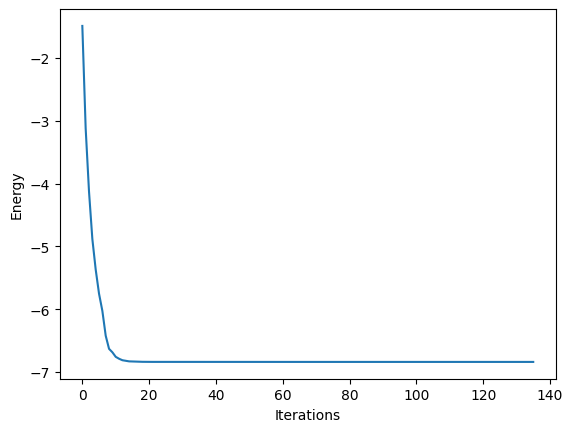

In [14]:
plt.plot(cost_hist)
plt.ylabel("Energy")
plt.xlabel("Iterations")
plt.show()

In [15]:
samples = run_sampler(opt_result.x, shots=1000)
samples

{'011101': 86,
 '001101': 59,
 '010110': 65,
 '101010': 6,
 '010101': 73,
 '010100': 81,
 '011110': 67,
 '101101': 14,
 '011100': 99,
 '111100': 4,
 '101110': 21,
 '011011': 8,
 '001110': 72,
 '101100': 27,
 '001100': 81,
 '000110': 14,
 '000100': 10,
 '110011': 1,
 '111010': 2,
 '001010': 17,
 '011111': 17,
 '001111': 16,
 '010111': 9,
 '110110': 5,
 '111101': 10,
 '011000': 11,
 '100101': 3,
 '001000': 7,
 '010010': 19,
 '101000': 3,
 '001011': 3,
 '010011': 3,
 '101001': 2,
 '011010': 20,
 '001001': 8,
 '101111': 7,
 '000101': 12,
 '011001': 5,
 '110100': 5,
 '010000': 5,
 '000111': 4,
 '000010': 4,
 '111110': 6,
 '100001': 1,
 '010001': 2,
 '000011': 1,
 '100110': 2,
 '111111': 1,
 '100011': 1,
 '000001': 1}

In [16]:
samples_top = {i: j for i, j in samples.items() if j > 50}
samples_top

{'011101': 86,
 '001101': 59,
 '010110': 65,
 '010101': 73,
 '010100': 81,
 '011110': 67,
 '011100': 99,
 '001110': 72,
 '001100': 81}

## Step 4: Visualize results in qse

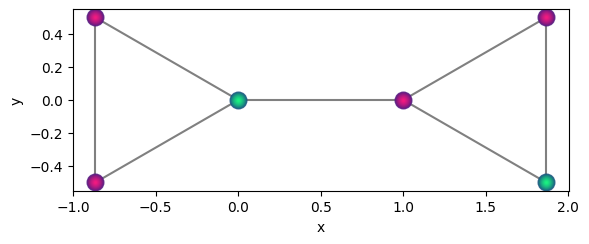

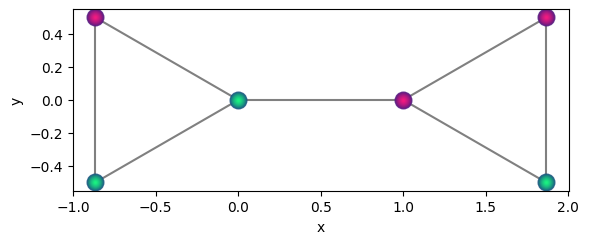

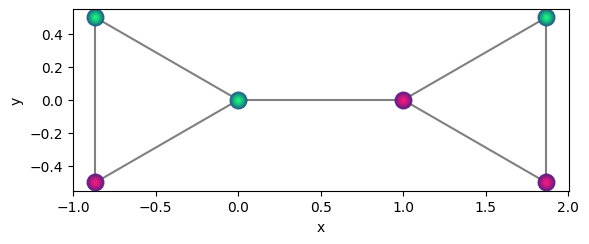

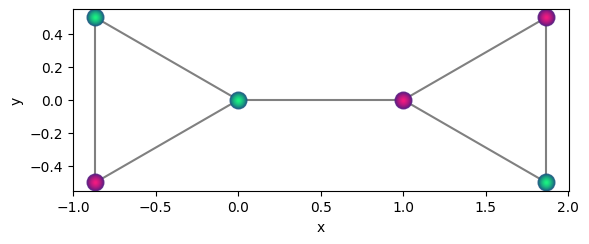

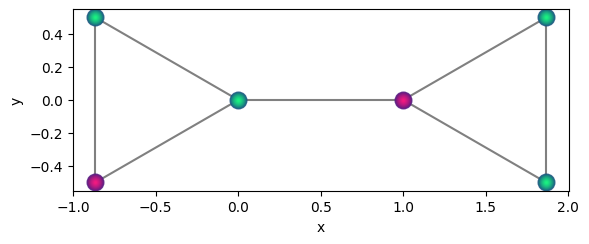

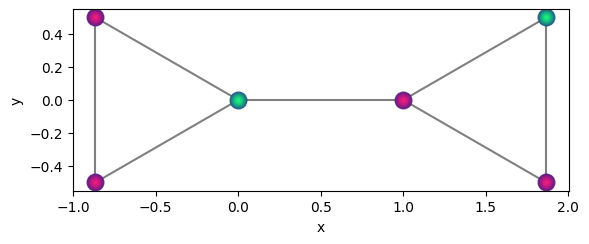

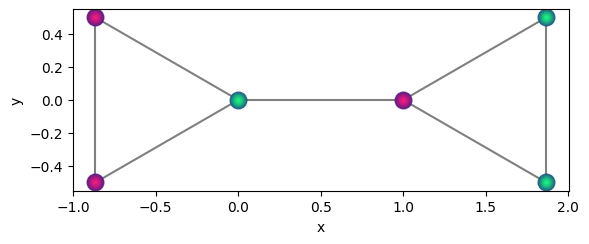

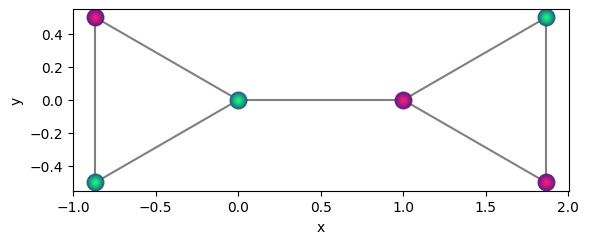

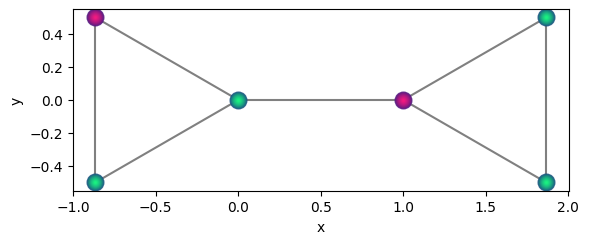

In [17]:
for s in samples_top.keys():
    qbits.draw(colouring=s, radius="nearest")